In [1]:
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
import rpy2
from pprint import pprint
import re
import numpy as np
import pickle
from skbio.alignment import StripedSmithWaterman

In [2]:
path = "../../david_eccles_bc_ideas/"
SRATE = 5000

In [3]:
robjects.r['load']("../../david_eccles_bc_ideas/mtDNA_mappable_called_with_rawSignal.Rdata")

<StrVector - Python:0x7f3c77143448 / R:0x30d7068>
['nanopore.bundled']

In [4]:
data = numpy2ri.ri2py(robjects.r['nanopore.bundled'])

In [5]:
files = !ls ../../david_eccles_bc_ideas/processed/ | grep fast5

In [85]:
n = 0
file = files[n]

In [118]:
result = re.search(r'_ch(\d+)_file(\d+)_', file)
file_id = int(result.group(2))
channel_id = int(result.group(1))
print(channel_id, file_id)

132 10


### Get data from RData

0 = reference
1 = called
3 = channel
8 = metrichor results (events)
9 = "mux"
10 = signal range 
11 = signal

In [119]:
ref = data[0][0]
channel_ids = [int(x) for x in data[3]]
file_ids = [int(x) for x in data[5]]
types = list(data[2].names)

In [120]:
## channel coords from rdata
coords = []
for i in range(0, len(data[10]), 2):
    coords.append((round(data[10][i]), round(data[10][i+1])))

all_raw = np.empty(round(max(data[10])))
all_raw.fill(-1)

pack all the available raw signal for the given channel in one array. 

In [121]:
for i, start_end in enumerate(coords):
    if channel_ids[i] == channel_id and file_ids[i] == file_id:
        start, end = start_end
        print(i, start)
        for k, sig in enumerate(data[11][i]):
            all_raw[start + k] = sig
        break

0 14263383


### Get events and sequence via poretools 

only look at the "template" seq for the beginning

In [122]:
called_seq = !poretools fasta {path+"processed/" + file} | grep template -A1 | grep -v ">"
called_seq = called_seq[0]

In [123]:
events = !poretools events {path+"processed/" + file} | grep template

file	strand	mean	start	stdv	length	model_state	model_level	move	p_model_state	mp_model_state	p_mp_model_state	p_A	p_C	p_G	p_T	raw_index

In [124]:
events = [line.split("\t") for line in events]

In [125]:
start = round(float(events[0][3]) * SRATE)
end = round(float(events[-1][3]) * SRATE)
print (start, end)

14263383 15169026


In [126]:
print(all_raw[14263383:14263483])

[ 273.  275.  276.  277.  270.  274.  271.  273.  269.  276.  279.  274.
  271.  276.  281.  271.  282.  278.  273.  278.  278.  274.  279.  276.
  271.  275.  279.  274.  273.  282.  282.  285.  274.  281.  277.  273.
  285.  280.  272.  270.  271.  279.  287.  282.  282.  286.  289.  282.
  286.  282.  292.  284.  285.  291.  275.  288.  284.  279.  283.  284.
  289.  290.  281.  286.  280.  278.  278.  279.  286.  279.  280.  289.
  284.  285.  289.  283.  279.  302.  275.  288.  293.  288.  281.  282.
  291.  285.  285.  287.  270.  287.  275.  282.  278.  288.  301.  285.
  281.  277.  278.  284.]


In [127]:
align_ref = StripedSmithWaterman(ref)

In [128]:
alignment = align_ref(called_seq)

In [129]:
raw_events = []
for ev in events: 
    start = round(float(ev[3]) * SRATE)
    end = round(start + float(ev[5]) * SRATE)
    kmer = ev[10]
    move = int(ev[8])
    raw_events.append((start, end, kmer, move))

In [130]:
print(raw_events[:20])

[(14263383, 14263425, 'CTACG', 0), (14263425, 14263799, 'ACACT', 1), (14263799, 14263877, 'CACTG', 1), (14263877, 14263958, 'CTGAA', 1), (14263958, 14263999, 'TGAAT', 1), (14263999, 14264045, 'GAATT', 1), (14264045, 14264166, 'AATTG', 1), (14264166, 14264323, 'ATTGG', 1), (14264323, 14264744, 'TGGGG', 2), (14264744, 14264887, 'GGGGG', 1), (14264887, 14265141, 'GGGGC', 1), (14265141, 14265630, 'GGGCT', 1), (14265630, 14265723, 'GGCTA', 1), (14265723, 14265736, 'CCAAC', 2), (14265736, 14265808, 'CAACC', 1), (14265808, 14265926, 'AACCG', 1), (14265926, 14266193, 'ACCGT', 1), (14266193, 14266404, 'CCGTA', 1), (14266404, 14266550, 'CGTAG', 2), (14266550, 14266719, 'TGCCA', 1)]


In [131]:
print(coords)

[(14263383, 15910759), (14263383, 15169249), (53054262, 55504866), (55559668, 56003939), (55763736, 56010845), (55559668, 55751863), (20841985, 23371298), (21744018, 23371561), (20841663, 21734142), (58611017, 61156099), (29733238, 30820677), (30178940, 30827270), (38452561, 39090146), (68761506, 69969365), (69336966, 69987497), (39203872, 41573334), (4338899, 5447779), (10117943, 12456817), (10111547, 11031551), (1610262, 4531694), (1610262, 2744863), (437216, 2539851), (1290055, 2547639), (25820667, 28176867), (28685564, 30723490), (29586312, 30723490), (28684851, 29577410), (36094944, 36994133), (36495057, 37002021), (36094944, 36484582), (38381291, 42077928), (60958967, 61482836), (60827554, 60948046), (62183810, 62976700), (13895041, 14757254), (14282593, 14760981), (14883605, 15979384), (16839366, 17570427), (17196412, 17583873), (11116981, 12913800), (12018853, 12918488), (28113526, 29953471), (50760609, 53369647), (52030192, 53380406), (11786742, 12203413), (11971416, 12210673)

In [132]:
for ev in raw_events[:10]:
    start = ev[0]
    print(all_raw[start])

273.0
287.0
281.0
271.0
302.0
270.0
232.0
234.0
257.0
298.0


In [133]:
from pylab import * 
import seaborn as sns
%matplotlib inline

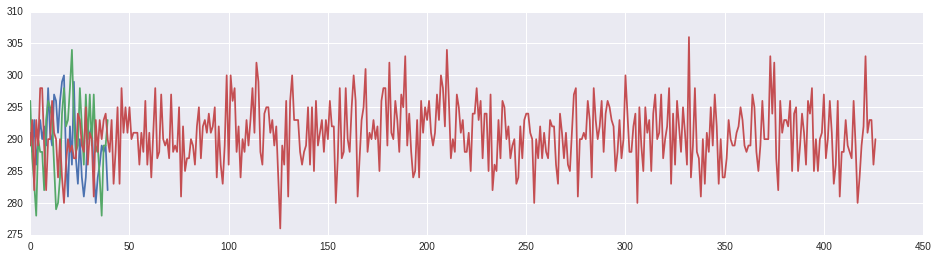

In [137]:
fig, ax = subplots(figsize = (16,4))
for ev in raw_events:
    start, end, kmer, move = ev
    if kmer == "GCCGC":
        ax.plot(list(all_raw[start:end]))

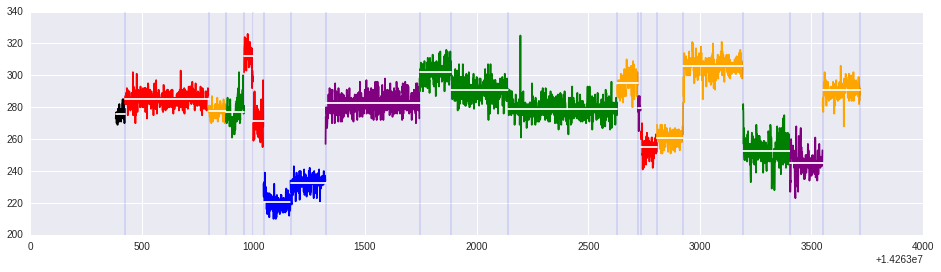

In [149]:
cols = {"A": "red", "T": "blue", "G": "green", "C": "orange"}
fig, ax = subplots(figsize = (16,4))
for ev in raw_events[:20]:
    start, end, kmer, move = ev
    if move == 1: 
        col = cols[kmer[2]]
    elif move == 0: 
        col = "black"
    else:
        col = "purple"
    ax.plot(range(start, end), list(all_raw[start:end]), color=col)
    ax.axvline(end, linewidth=.2)
    ax.plot((start, end), [mean(all_raw[start:end])] * 2, color="white")